# Exploring Title Popularity on Amazon Prime Video

## Introduction
In the vast universe of streaming content, Amazon Prime Video offers a plethora of movies and TV shows across the globe. But what makes a title popular? Is it the genre, the year of release, or perhaps the number of countries it's available in?

In this project, we aim to explore the factors influencing the popularity of titles on Amazon Prime Video. We'll analyze the dataset, uncover trends, and gain insights into what makes certain titles stand out.


### Step-1: Import neccessary libraries and load data

In [1]:
import pandas as pd

In [2]:
import pandas as pd
import boto3

# Define S3 bucket and file details
bucket_name = 'amazon-prime-analysis'  # My bucket name
file_key = 'data.csv'  # File name in the bucket

# Load data from S3
s3 = boto3.client('s3')
file_path = f"s3://{bucket_name}/{file_key}"

# Using Pandas to read the data into a DataFrame
data = pd.read_csv(file_path)
print("Data successfully loaded. Here are the first few rows:")
data.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


Data successfully loaded. Here are the first few rows:


,title,type,genres,releaseYear,imdbId,imdbAverageRating,imdbNumVotes,availableCountries
0,Blondie,movie,"Comedy, Family",1938.0,tt0029927,6.9,891.0,"US, ZA"
1,Ariel,movie,"Comedy, Crime, Romance",1988.0,tt0094675,7.4,8831.0,JP
2,Four Rooms,movie,Comedy,1995.0,tt0113101,6.7,112890.0,"AT, DE"
3,Judgment Night,movie,"Action, Crime, Drama",1993.0,tt0107286,6.6,19389.0,US
4,Forrest Gump,movie,"Drama, Romance",1994.0,tt0109830,8.8,2330852.0,"AD, AT, CU, DE, FR, GF, IN, JP, MC, PF, SN"


### Step-2: Cleaning Data

In [3]:
# Checking for missing values
print("Missing Values:\n", data.isnull().sum())

# Checking data types
print("\nData Types:\n", data.dtypes)

# Get a summary of the dataset
data.describe()

Missing Values:
 title                 1570
type                     0
genres                2006
releaseYear            174
imdbId                6170
imdbAverageRating     8452
imdbNumVotes          8452
availableCountries       0
dtype: int64

Data Types:
 title                  object
type                   object
genres                 object
releaseYear           float64
imdbId                 object
imdbAverageRating     float64
imdbNumVotes          float64
availableCountries     object
dtype: object


,releaseYear,imdbAverageRating,imdbNumVotes
count,69575.000000,61297.000000,6.129700e+04
mean,2007.263255,5.950794,1.328667e+04
std,18.998557,1.370108,7.484578e+04
min,1902.000000,1.000000,5.000000e+00
25%,2003.000000,5.100000,1.030000e+02
50%,2015.000000,6.100000,4.530000e+02
75%,2019.000000,6.900000,2.369000e+03
max,2026.000000,9.900000,2.978913e+06


In [4]:
# Drop rows where title is missing, as it's essential
data = data.dropna(subset=['title'])

data.drop(columns=['imdbId'], inplace=True)

# Fill missing numeric columns with appropriate values 
data['imdbAverageRating'].fillna(data['imdbAverageRating'].mean(), inplace=True)
data['imdbNumVotes'].fillna(data['imdbNumVotes'].median(), inplace=True)
data['releaseYear'].fillna(data['releaseYear'].median(), inplace=True)

# Handle missing genres by replacing with 'Unknown'
data['genres'].fillna('Unknown', inplace=True)

# Add a new column for the number of available countries
data['num_countries'] = data['availableCountries'].apply(lambda x: len(x.split(', ')) if isinstance(x, str) else 0)

# Confirm no missing values remain
print("Missing Values After Cleaning:\n", data.isnull().sum())

Missing Values After Cleaning:
 title                 0
type                  0
genres                0
releaseYear           0
imdbAverageRating     0
imdbNumVotes          0
availableCountries    0
num_countries         0
dtype: int64


## Step-3: Exploratory Data Analysis

### 1. What are the most common genres?

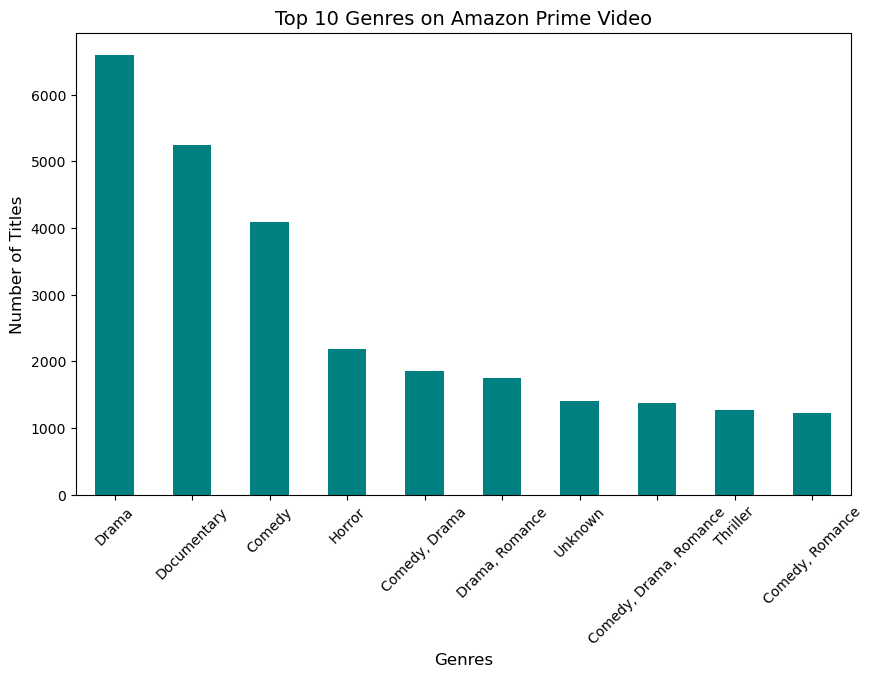

In [5]:
# Count the frequency of each genre
genre_counts = data['genres'].value_counts().head(10)

# Plot the top genres
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='teal')
plt.title('Top 10 Genres on Amazon Prime Video', fontsize=14)
plt.xlabel('Genres', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(rotation=45)
plt.show()

Top Genres:

Drama is the most common genre, followed by Documentary and Comedy. This suggests that audiences might have a preference for emotionally engaging content or factual storytelling.

### 2. What is the distribution of IMDb ratings?

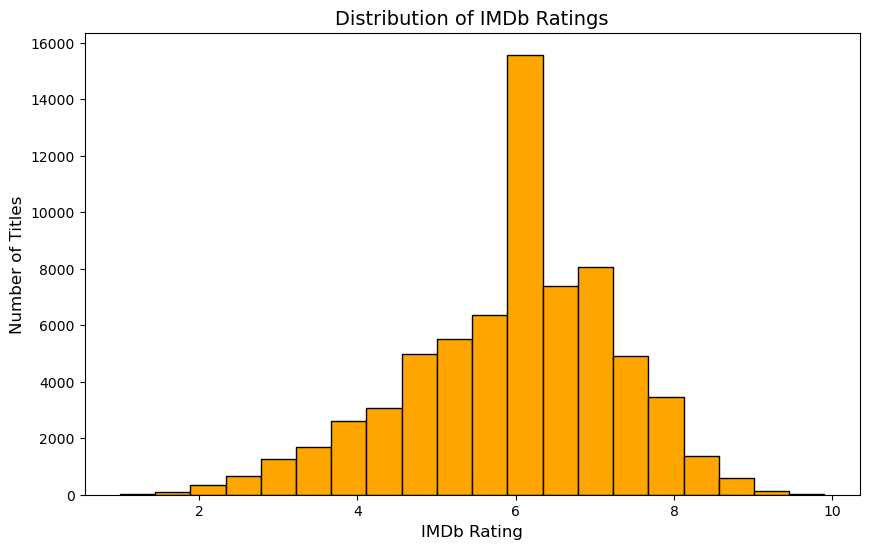

In [6]:
# Plot the distribution of IMDb ratings
plt.figure(figsize=(10, 6))
data['imdbAverageRating'].hist(bins=20, color='orange', edgecolor='black', grid=False)
plt.title('Distribution of IMDb Ratings', fontsize=14)
plt.xlabel('IMDb Rating', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.show()

Distribution of IMDb Ratings:

Ratings are mostly clustered between 5 and 7, with relatively fewer titles receiving very high (9-10) or very low (1-2) ratings. This indicates a tendency for most titles to be rated as average or slightly above average.

### 3. Do titles available in more countries tend to have higher ratings?

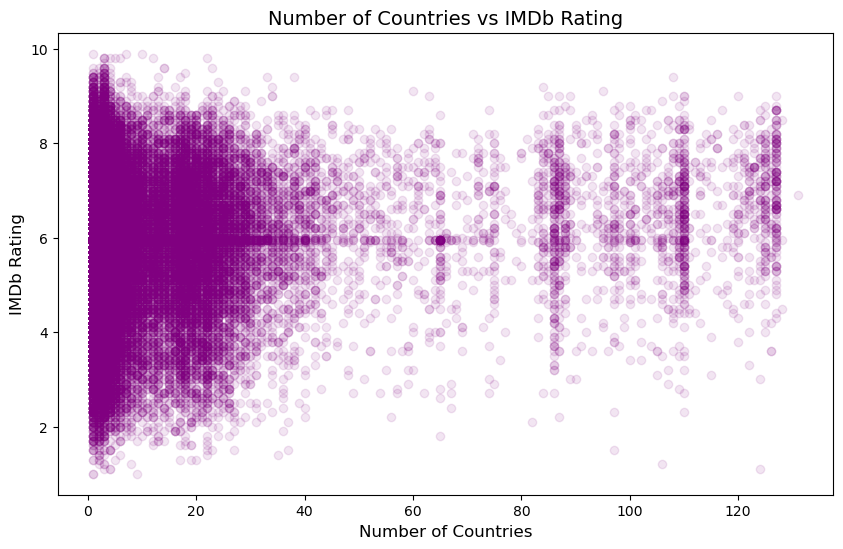

In [9]:
# Scatter plot: Number of countries vs IMDb rating
plt.figure(figsize=(10, 6))
plt.scatter(data['num_countries'], data['imdbAverageRating'], alpha=0.1, color='purple')
plt.title('Number of Countries vs IMDb Rating', fontsize=14)
plt.xlabel('Number of Countries', fontsize=12)
plt.ylabel('IMDb Rating', fontsize=12)
plt.show()

Number of Countries vs IMDb Rating:

There isn’t a very strong visible correlation between the number of countries a title is available in and its IMDb rating. However, we can perform statistical analysis to confirm this.

### 4. What is the popular Genre

In [10]:
# Calculate the average IMDb rating and popularity metric for each genre
genre_analysis = data.groupby('genres').agg({
    'imdbAverageRating': 'mean',
    'imdbNumVotes': 'mean',
    'num_countries': 'mean'
}).sort_values(by='imdbAverageRating', ascending=False)

# Display top 10 genres by IMDb rating
genre_analysis.head(10)

,imdbAverageRating,imdbNumVotes,num_countries
genres,,,
"Music, Talk-Show",9.1,13.0,1.0
"Animation, Family, War",8.8,559.0,22.0
"Family, Reality-TV, Talk-Show",8.8,84.0,1.0
"Documentary, Family, Musical",8.8,28.0,1.0
"Documentary, Family, Reality-TV",8.8,423.0,9.0
"Adventure, Sport, Talk-Show",8.7,130679.0,14.0
"Comedy, Sport, Talk-Show",8.7,88914.0,127.0
"Family, Documentary, Reality",8.7,19.0,1.0
"Adventure, News",8.6,113.0,3.0


Popularity by Genre:

Genres like Music, Talk-Show, Animation, Family, War, and Documentary, Family, Musical have the highest IMDb ratings. However, these genres are typically available in fewer countries, which might indicate they are niche or region-specific.

### 5.Analyzing Popularity by Release Year

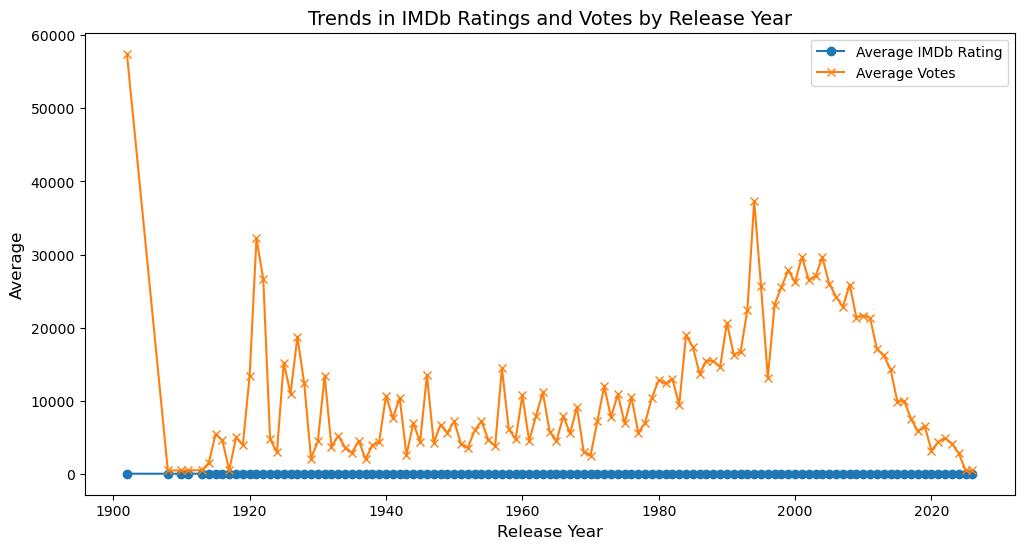

In [11]:
# Group by release year to find trends in average IMDb rating and popularity
release_year_analysis = data.groupby('releaseYear').agg({
    'imdbAverageRating': 'mean',
    'imdbNumVotes': 'mean'
}).sort_index()

# Plot trends over the years
plt.figure(figsize=(12, 6))
plt.plot(release_year_analysis.index, release_year_analysis['imdbAverageRating'], label='Average IMDb Rating', marker='o')
plt.plot(release_year_analysis.index, release_year_analysis['imdbNumVotes'], label='Average Votes', marker='x')
plt.title('Trends in IMDb Ratings and Votes by Release Year', fontsize=14)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Average', fontsize=12)
plt.legend()

plt.show()

Popularity by Release Year:

Average IMDb ratings have remained relatively stable over the years. Average votes exhibit sharp fluctuations, especially for older titles. This could be due to a small number of highly rated and widely voted classics.

### 6.Popularity by Number of Countries

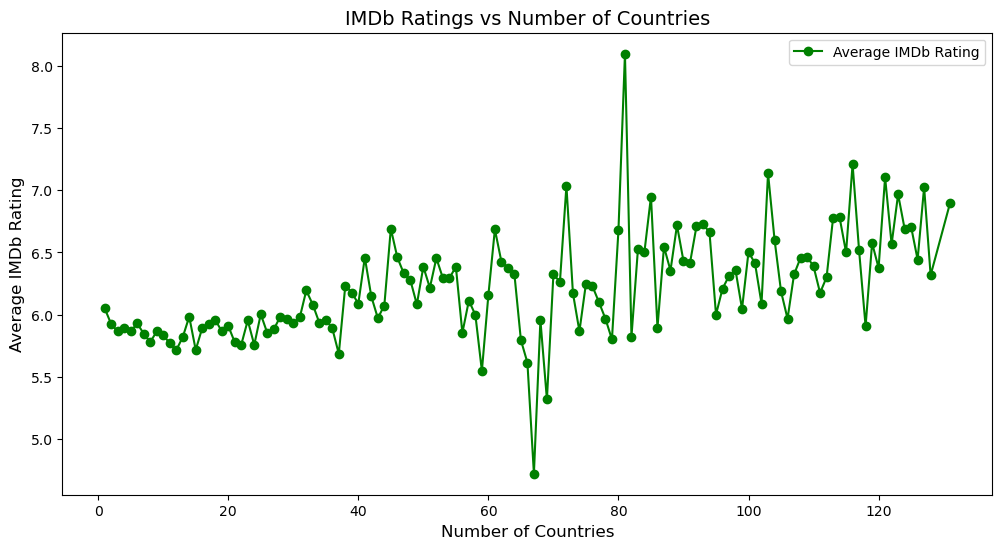

In [12]:
# Group titles by the number of countries available and analyze average rating and votes
country_analysis = data.groupby('num_countries').agg({
    'imdbAverageRating': 'mean',
    'imdbNumVotes': 'mean'
}).sort_index()

# Plot trends in ratings by the number of countries
plt.figure(figsize=(12, 6))
plt.plot(country_analysis.index, country_analysis['imdbAverageRating'], label='Average IMDb Rating', color='green', marker='o')
plt.title('IMDb Ratings vs Number of Countries', fontsize=14)
plt.xlabel('Number of Countries', fontsize=12)
plt.ylabel('Average IMDb Rating', fontsize=12)
plt.legend()
plt.show()

Titles available in more countries tend to have slightly higher IMDb ratings. There is variability, but the trend suggests broader availability may correlate with higher ratings.

## Conclusion

This analysis explored factors that contribute to the popularity of titles on Amazon Prime Video. Key findings include:

1. **Genres**: Certain niche genres like "Music, Talk-Show" and "Animation, Family, War" tend to have higher IMDb ratings. However, their limited availability indicates they might appeal to specific audiences.
2. **Release Year**: IMDb ratings remain stable across decades, while votes show variability, particularly for older, iconic titles.
3. **Country Availability**: Titles available in more countries generally have higher ratings, suggesting that broader distribution can boost popularity.

### Recommendations:
- Invest in globally popular genres like *Comedy* and *Adventure* to maximize reach.
- Expand the availability of highly rated niche content to new regions to grow its audience base.
- Leverage historical titles with high votes in promotional campaigns to attract nostalgia-driven viewers.

These insights can help content strategists on Amazon Prime Video make informed decisions about content acquisition and distribution.

## Step-4: Training the Model

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

# Create a target column: 1 for "Popular", 0 for "Not Popular"
data['popular'] = np.where(data['imdbAverageRating'] > 7, 1, 0)

# One-hot encode the 'genres' column
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
genres_encoded = encoder.fit_transform(data[['genres']])

# Normalize numerical features
scaler = StandardScaler()
numerical_features = scaler.fit_transform(data[['num_countries', 'imdbNumVotes', 'releaseYear']])

# Combine all features into one array
X = np.hstack((genres_encoded, numerical_features))
y = data['popular']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (54543, 1351)
Testing set size: (13636, 1351)


In [15]:
! pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.2 MB/s eta 0:00:00


## Step-5: Model Evaluations

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Initialize models
logistic_model = LogisticRegression(max_iter=1000)
random_forest_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Train models
logistic_model.fit(X_train, y_train)
random_forest_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Evaluate models
models = {
    "Logistic Regression": logistic_model,
    "Random Forest": random_forest_model,
    "XGBoost": xgb_model
}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"\n=== {model_name} ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [22:24:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Logistic Regression ===
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.82      0.98      0.89     10831
           1       0.63      0.15      0.24      2805

    accuracy                           0.81     13636
   macro avg       0.72      0.56      0.56     13636
weighted avg       0.78      0.81      0.76     13636


=== Random Forest ===
Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.85      0.93      0.89     10831
           1       0.57      0.34      0.43      2805

    accuracy                           0.81     13636
   macro avg       0.71      0.64      0.66     13636
weighted avg       0.79      0.81      0.79     13636


=== XGBoost ===
Accuracy: 0.82
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     10831
           1       0.64      0.30      0.41      2805

    accuracy                           0.82     13636
   macro avg  